In [249]:
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

import pandas as pd
import tqdm
import h5py
from Bio import SeqIO

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# import keras functions
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Input, Flatten, LSTM, Dropout, Bidirectional, GRU, SpatialDropout1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# performance matrices
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score

# plots
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Lambda, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2

from tensorflow.keras import backend as K
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer, GlobalAveragePooling1D, Input, GlobalAveragePooling2D

In [250]:
def plot_save(history, filename):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['auc_roc'], label='Train AUC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC')
    plt.legend()
    plt.show()

In [251]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [252]:
test_positive_ST_embedding_pos = read_h5("../embeddings/test_positive_ST_embedding.h5")
test_negative_ST_embedding_pos = read_h5("../embeddings/test_negative_ST_embedding.h5")

In [253]:
test_positive_ST_labels = np.ones(test_positive_ST_embedding_pos.shape[0])
test_negative_ST_labels = np.zeros(test_negative_ST_embedding_pos.shape[0])

test_ST_labels = np.concatenate((test_positive_ST_labels, test_negative_ST_labels), axis = 0)
X_test_full_ST_embedding = np.vstack((test_positive_ST_embedding_pos, test_negative_ST_embedding_pos))

In [254]:
train_positive_ST_embedding_pos = read_h5("../embeddings/train_positive_ST_embedding.h5")
train_negative_ST_embedding_pos = read_h5("../embeddings/train_negative_ST_embedding.h5")

In [255]:
train_positive_ST_labels = np.ones(train_positive_ST_embedding_pos.shape[0])
train_negative_ST_labels = np.zeros(train_negative_ST_embedding_pos.shape[0])

train_ST_labels = np.concatenate((train_positive_ST_labels, train_negative_ST_labels), axis = 0)
X_train_full_ST_embedding = np.vstack((train_positive_ST_embedding_pos, train_negative_ST_embedding_pos))

In [256]:
X_train_full_ST_embedding.shape, train_ST_labels.shape,  X_test_full_ST_embedding.shape, test_ST_labels.shape

((1779, 1024), (1779,), (446, 1024), (446,))

In [257]:
def get_input_for_embedding(fasta_file):
    # This is returning just integers to feed to embedding layer
    
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    #print(char_to_int)
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        try:
            integer_encoded = [char_to_int[char] for char in data]
        except:
            continue
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    print(encodings.shape)
    return encodings


# convert sequences to integer encoding, for embedding
test_positive_ST_CNN = get_input_for_embedding('../dataset/test_Pos_ST.fasta')
test_negative_ST_CNN = get_input_for_embedding('../dataset/test_Neg_ST.fasta')

train_positive_ST_CNN = get_input_for_embedding('../dataset/train_Pos_ST.fasta')
train_negative_ST_CNN = get_input_for_embedding('../dataset/train_Neg_ST.fasta')

(222, 33)
(224, 33)
(890, 33)
(889, 33)


In [258]:
X_train_CNN = np.vstack((train_positive_ST_CNN, train_negative_ST_CNN))
X_test_CNN = np.vstack((test_positive_ST_CNN, test_negative_ST_CNN))
X_train_CNN.shape, X_test_CNN.shape, train_ST_labels.shape, test_ST_labels.shape

((1779, 33), (446, 33), (1779,), (446,))

In [259]:
X_train_CNN, train_ST_labels

(array([[ 2, 18, 16, ..., 15, 14, 15],
        [15,  7, 12, ...,  1, 16,  5],
        [ 5, 14,  5, ..., 15, 16, 18],
        ...,
        [ 0, 14, 10, ..., 19, 15,  7],
        [ 8,  0, 15, ...,  1, 10, 10],
        [ 3,  0, 10, ...,  3, 18, 11]]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [260]:
# Pretraining with Phosphorylation dataset

# S
pre_test_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_S.fasta')
pre_test_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_S.fasta')

pre_train_positive_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_S.fasta')
pre_train_negative_S_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_S.fasta')

# T
pre_test_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_pos_T.fasta')
pre_test_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/test_neg_T.fasta')

pre_train_positive_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_pos_T.fasta')
pre_train_negative_T_CNN = get_input_for_embedding('../dataset/phospho.elm_dataset/phosphoELM_all_latest.dump/train_neg_T.fasta')


pre_test_pos_ST_CNN = np.vstack((pre_test_positive_S_CNN, pre_test_positive_T_CNN))
pre_test_neg_ST_CNN = np.vstack((pre_test_negative_S_CNN, pre_test_negative_T_CNN))

pre_train_pos_ST_CNN = np.vstack((pre_train_positive_S_CNN, pre_train_positive_T_CNN))
pre_train_neg_ST_CNN = np.vstack((pre_train_negative_S_CNN, pre_train_negative_T_CNN))

(3367, 33)
(3367, 33)
(13465, 33)
(13461, 33)
(856, 33)
(858, 33)
(3420, 33)
(3421, 33)


In [261]:
pre_test_pos_ST_CNN.shape, pre_test_neg_ST_CNN.shape, pre_train_pos_ST_CNN.shape, pre_train_neg_ST_CNN.shape

((4223, 33), (4225, 33), (16885, 33), (16882, 33))

In [262]:
pre_test_ST = np.vstack((pre_test_pos_ST_CNN, pre_test_neg_ST_CNN))

pre_test_positive_ST_labels = np.ones(pre_test_pos_ST_CNN.shape[0])
pre_test_negative_ST_labels = np.zeros(pre_test_neg_ST_CNN.shape[0])

pre_test_ST_labels = np.concatenate((pre_test_positive_ST_labels, pre_test_negative_ST_labels), axis = 0)
pre_test_ST.shape, pre_test_ST_labels.shape

((8448, 33), (8448,))

In [263]:
pre_train_ST = np.vstack((pre_train_pos_ST_CNN, pre_train_neg_ST_CNN))

pre_train_positive_ST_labels = np.ones(pre_train_pos_ST_CNN.shape[0])
pre_train_negative_ST_labels = np.zeros(pre_train_neg_ST_CNN.shape[0])

pre_train_ST_labels = np.concatenate((pre_train_positive_ST_labels, pre_train_negative_ST_labels), axis = 0)
pre_train_ST.shape, pre_train_ST_labels.shape

((33767, 33), (33767,))

In [264]:
### Assemble dataset for pretraining CNN and Transformer from Phophosite_org

# Pretraining with Phosphosite ORG dataset

# S
pre_test_positive_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_pos_S.fasta')
pre_test_negative_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_neg_S.fasta')

pre_train_positive_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_pos_S.fasta')
pre_train_negative_S_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_neg_S.fasta')

# T
pre_test_positive_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_pos_T.fasta')
pre_test_negative_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/test_neg_T.fasta')

pre_train_positive_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_pos_T.fasta')
pre_train_negative_T_CNN_ORG = get_input_for_embedding('../dataset/phosphosite_org/train_neg_T.fasta')


pre_test_pos_ST_CNN_ORG = np.vstack((pre_test_positive_S_CNN_ORG, pre_test_positive_T_CNN_ORG))
pre_test_neg_ST_CNN_ORG = np.vstack((pre_test_negative_S_CNN_ORG, pre_test_negative_T_CNN_ORG))

pre_train_pos_ST_CNN_ORG = np.vstack((pre_train_positive_S_CNN_ORG, pre_train_positive_T_CNN_ORG))
pre_train_neg_ST_CNN_ORG = np.vstack((pre_train_negative_S_CNN_ORG, pre_train_negative_T_CNN_ORG))


pre_test_ST_CNN_ORG = np.vstack((pre_test_pos_ST_CNN_ORG, pre_test_neg_ST_CNN_ORG))
pre_train_ST_CNN_ORG = np.vstack((pre_train_pos_ST_CNN_ORG, pre_train_neg_ST_CNN_ORG))
pre_test_ST_CNN_ORG.shape, pre_train_ST_CNN_ORG.shape

(24736, 33)
(24738, 33)
(98936, 33)
(98933, 33)
(10572, 33)
(10573, 33)
(42286, 33)
(42284, 33)


((70619, 33), (282439, 33))

In [265]:
pre_test_positive_ST_ORG_labels = np.ones(pre_test_pos_ST_CNN_ORG.shape[0])
pre_test_negative_ST_ORG_labels = np.zeros(pre_test_neg_ST_CNN_ORG.shape[0])

pre_test_ST_ORG_labels = np.concatenate((pre_test_positive_ST_ORG_labels, pre_test_negative_ST_ORG_labels), axis = 0)
pre_test_ST_CNN_ORG.shape, pre_test_ST_ORG_labels.shape

((70619, 33), (70619,))

In [266]:
pre_train_positive_ST_ORG_labels = np.ones(pre_train_pos_ST_CNN_ORG.shape[0])
pre_train_negative_ST_ORG_labels = np.zeros(pre_train_neg_ST_CNN_ORG.shape[0])

pre_train_ST_ORG_labels = np.concatenate((pre_train_positive_ST_ORG_labels, pre_train_negative_ST_ORG_labels), axis = 0)
pre_train_ST_CNN_ORG.shape, pre_train_ST_ORG_labels.shape

((282439, 33), (282439,))

In [267]:
### Assemble dataset for pretraining CNN and Transformer from DBPAF

# Pretraining with Phosphosite DBPAF dataset

# S
pre_test_positive_S_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/test_pos_S.fasta')
pre_test_negative_S_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/test_neg_S.fasta')

pre_train_positive_S_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/train_pos_S.fasta')
pre_train_negative_S_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/train_neg_S.fasta')

# T
pre_test_positive_T_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/test_pos_T.fasta')
pre_test_negative_T_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/test_neg_T.fasta')

pre_train_positive_T_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/train_pos_T.fasta')
pre_train_negative_T_CNN_DBPAF = get_input_for_embedding('../dataset/dbpaf/train_neg_T.fasta')


pre_test_pos_ST_CNN_DBPAF = np.vstack((pre_test_positive_S_CNN_DBPAF, pre_test_positive_T_CNN_DBPAF))
pre_test_neg_ST_CNN_DBPAF = np.vstack((pre_test_negative_S_CNN_DBPAF, pre_test_negative_T_CNN_DBPAF))

pre_train_pos_ST_CNN_DBPAF = np.vstack((pre_train_positive_S_CNN_DBPAF, pre_train_positive_T_CNN_DBPAF))
pre_train_neg_ST_CNN_DBPAF = np.vstack((pre_train_negative_S_CNN_DBPAF, pre_train_negative_T_CNN_DBPAF))


pre_test_ST_CNN_DBPAF = np.vstack((pre_test_pos_ST_CNN_DBPAF, pre_test_neg_ST_CNN_DBPAF))
pre_train_ST_CNN_DBPAF = np.vstack((pre_train_pos_ST_CNN_DBPAF, pre_train_neg_ST_CNN_DBPAF))
pre_test_ST_CNN_DBPAF.shape, pre_train_ST_CNN_DBPAF.shape

(25597, 33)
(25595, 33)
(102385, 33)
(102362, 33)
(11037, 33)
(11037, 33)
(44150, 33)
(44137, 33)


((73266, 33), (293034, 33))

In [268]:
pre_test_positive_ST_DBPAF_labels = np.ones(pre_test_pos_ST_CNN_DBPAF.shape[0])
pre_test_negative_ST_DBPAF_labels = np.zeros(pre_test_neg_ST_CNN_DBPAF.shape[0])

pre_test_ST_DBPAF_labels = np.concatenate((pre_test_positive_ST_DBPAF_labels, pre_test_negative_ST_DBPAF_labels), axis = 0)
pre_test_ST_CNN_DBPAF.shape, pre_test_ST_DBPAF_labels.shape

((73266, 33), (73266,))

In [269]:
pre_train_positive_ST_DBPAF_labels = np.ones(pre_train_pos_ST_CNN_DBPAF.shape[0])
pre_train_negative_ST_DBPAF_labels = np.zeros(pre_train_neg_ST_CNN_DBPAF.shape[0])

pre_train_ST_DBPAF_labels = np.concatenate((pre_train_positive_ST_DBPAF_labels, pre_train_negative_ST_DBPAF_labels), axis = 0)
pre_train_ST_CNN_DBPAF.shape, pre_train_ST_DBPAF_labels.shape

((293034, 33), (293034,))

In [298]:
##### Combine Phosphosite ORG with DBPAF ELM

pre_test_ST_CNN = np.vstack((pre_test_ST_CNN_ORG, pre_test_ST_CNN_DBPAF))
pre_test_ST_CNN_labels = np.concatenate((pre_test_ST_ORG_labels, pre_test_ST_DBPAF_labels), axis = 0)
pre_test_ST_CNN.shape, pre_test_ST_CNN_labels.shape

((143885, 33), (143885,))

In [299]:
pre_train_ST_CNN = np.vstack((pre_train_ST_CNN_ORG, pre_train_ST_CNN_DBPAF))
pre_train_ST_CNN_labels = np.concatenate((pre_train_ST_ORG_labels, pre_train_ST_DBPAF_labels), axis = 0)
pre_train_ST_CNN.shape, pre_train_ST_CNN_labels.shape

((575473, 33), (575473,))

In [277]:
### Assemble dataset for pretraining embeddings

pre_test_positive_S_embedding = read_h5("../embeddings/phospho.elm/test_positive_S_embedding.h5")
pre_test_negative_S_embedding = read_h5("../embeddings/phospho.elm/test_negative_S_embedding.h5")

pre_train_positive_S_embedding = read_h5("../embeddings/phospho.elm/train_positive_S_embedding.h5")
pre_train_negative_S_embedding = read_h5("../embeddings/phospho.elm/train_negative_S_embedding.h5")

pre_test_positive_T_embedding = read_h5("../embeddings/phospho.elm/test_positive_T_embedding.h5")
pre_test_negative_T_embedding = read_h5("../embeddings/phospho.elm/test_negative_T_embedding.h5")

pre_train_positive_T_embedding = read_h5("../embeddings/phospho.elm/train_positive_T_embedding.h5")
pre_train_negative_T_embedding = read_h5("../embeddings/phospho.elm/train_negative_T_embedding.h5")

pre_test_positive_S_embedding.shape, pre_test_negative_S_embedding.shape, pre_train_positive_S_embedding.shape, pre_train_negative_S_embedding.shape 

((3367, 1024), (3369, 1024), (13466, 1024), (13468, 1024))

In [278]:
pre_test_positive_T_embedding.shape, pre_test_negative_T_embedding.shape, pre_train_positive_T_embedding.shape, pre_train_negative_T_embedding.shape

((856, 1024), (858, 1024), (3420, 1024), (3422, 1024))

In [279]:
pre_test_pos_ST_Embed = np.vstack((pre_test_positive_S_embedding, pre_test_positive_T_embedding))
pre_test_neg_ST_Embed = np.vstack((pre_test_negative_S_embedding, pre_test_negative_T_embedding))

pre_train_pos_ST_Embed = np.vstack((pre_train_positive_S_embedding, pre_train_positive_T_embedding))
pre_train_neg_ST_Embed = np.vstack((pre_train_negative_S_embedding, pre_train_negative_T_embedding))

pre_test_pos_ST_Embed.shape, pre_test_neg_ST_Embed.shape, pre_train_pos_ST_Embed.shape, pre_train_neg_ST_Embed.shape

((4223, 1024), (4227, 1024), (16886, 1024), (16890, 1024))

In [280]:
pre_train_ST_Embed = np.vstack((pre_train_pos_ST_Embed, pre_train_neg_ST_Embed))

pre_train_positive_ST_Embed_labels = np.ones(pre_train_pos_ST_Embed.shape[0])
pre_train_negative_ST_Embed_labels = np.zeros(pre_train_neg_ST_Embed.shape[0])

pre_train_ST_labels_Embed = np.concatenate((pre_train_positive_ST_Embed_labels, pre_train_negative_ST_Embed_labels), axis = 0)
pre_train_ST_Embed.shape, pre_train_ST_labels_Embed.shape

((33776, 1024), (33776,))

In [281]:
pre_test_ST_Embed = np.vstack((pre_test_pos_ST_Embed, pre_test_neg_ST_Embed))

pre_test_positive_ST_Embed_labels = np.ones(pre_test_pos_ST_Embed.shape[0])
pre_test_negative_ST_Embed_labels = np.zeros(pre_test_neg_ST_Embed.shape[0])

pre_test_ST_labels_Embed = np.concatenate((pre_test_positive_ST_Embed_labels, pre_test_negative_ST_Embed_labels), axis = 0)
pre_test_ST_Embed.shape, pre_test_ST_labels_Embed.shape

((8450, 1024), (8450,))

PRE Training CNN model...
Epoch 1/10
2248/2248 [==============================] - 41s 18ms/step - loss: 0.6115 - accuracy: 0.6642 - auc_roc: 0.7237 - val_loss: 0.6108 - val_accuracy: 0.6796 - val_auc_roc: 0.7468
Epoch 2/10
2248/2248 [==============================] - 44s 20ms/step - loss: 0.5972 - accuracy: 0.6781 - auc_roc: 0.7422 - val_loss: 0.6020 - val_accuracy: 0.6837 - val_auc_roc: 0.7523
Epoch 3/10
2248/2248 [==============================] - 39s 17ms/step - loss: 0.5927 - accuracy: 0.6818 - auc_roc: 0.7474 - val_loss: 0.5997 - val_accuracy: 0.6834 - val_auc_roc: 0.7541
Epoch 4/10
2248/2248 [==============================] - 39s 17ms/step - loss: 0.5901 - accuracy: 0.6844 - auc_roc: 0.7506 - val_loss: 0.5950 - val_accuracy: 0.6857 - val_auc_roc: 0.7556
Epoch 5/10
2248/2248 [==============================] - 44s 20ms/step - loss: 0.5874 - accuracy: 0.6868 - auc_roc: 0.7536 - val_loss: 0.5955 - val_accuracy: 0.6861 - val_auc_roc: 0.7575
Epoch 6/10
2248/2248 [======================

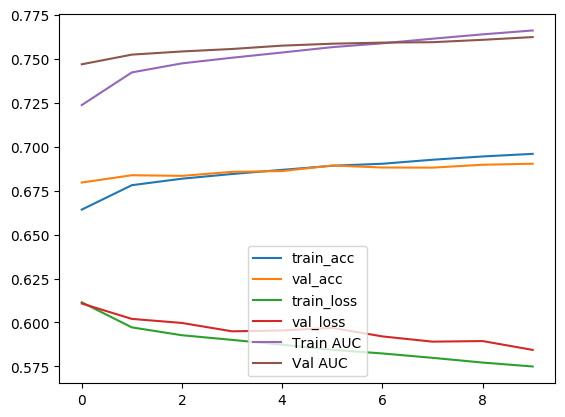


 Acc: 0.7134232954545454, MCC: 0.47407488755927474, SN:0.9308548425290079, SP:0.49609467455621303, 
 CM:[[2096 2129]
 [ 292 3931]]


In [300]:
# Pretraining CNN

def CNN_model():
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(128, kernel_size=(16, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(8, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model


n_epo_cnn = 40

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_A.summary()

print("PRE Training CNN model...")

checkpointer = ModelCheckpoint(filepath="../models/pre_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

pre_history_A = model_A.fit(pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=1024, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels))
    
#pre_history_A = model_A.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
#    validation_data=(pre_test_ST, pre_test_ST_labels))

# Save model
#model_A.save_weights('../models/pre_model_A.h5')

y_pred = model_A.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels, y_pred)
acc = accuracy_score(pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Pre Training Embedding model...
Epoch 1/20
106/106 [==============================] - 2s 13ms/step - loss: 0.5433 - accuracy: 0.7355 - auc_roc: 0.8038 - val_loss: 0.5008 - val_accuracy: 0.7650 - val_auc_roc: 0.8377
Epoch 2/20
106/106 [==============================] - 1s 8ms/step - loss: 0.5143 - accuracy: 0.7549 - auc_roc: 0.8265 - val_loss: 0.5002 - val_accuracy: 0.7620 - val_auc_roc: 0.8378
Epoch 3/20
106/106 [==============================] - 1s 13ms/step - loss: 0.5040 - accuracy: 0.7600 - auc_roc: 0.8339 - val_loss: 0.4991 - val_accuracy: 0.7656 - val_auc_roc: 0.8414
Epoch 4/20
106/106 [==============================] - 1s 11ms/step - loss: 0.4997 - accuracy: 0.7647 - auc_roc: 0.8373 - val_loss: 0.4982 - val_accuracy: 0.7703 - val_auc_roc: 0.8411
Epoch 5/20
106/106 [==============================] - 1s 8ms/step - loss: 0.4947 - accuracy: 0.7651 - auc_roc: 0.8409 - val_loss: 0.4954 - val_accuracy: 0.7693 - val_auc_roc: 0.8414
Epoch 6/20
106/106 [==============================] - 1

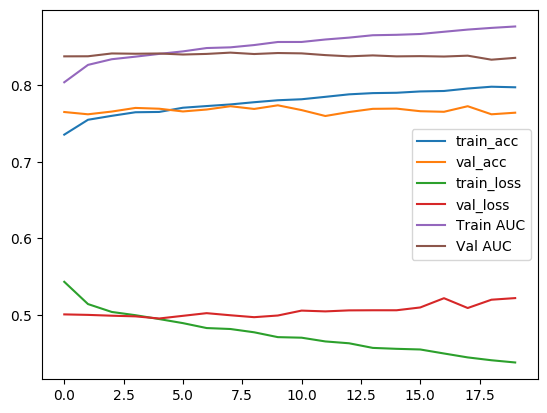



 Acc: 0.7737529691211401, MCC: 0.547815259183534, SN:0.7567567567567568, SP:0.7907390917186109, 
 CM:[[2664  705]
 [ 819 2548]]


In [247]:
########### Model B

def prot_t5_model():
    # prot_t5
    M1_input = Input(shape=(1024,))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.4)(M1_dense_1)
    M1_dense_2 = Dense(128, activation='relu')(drop_out)
    drop_out = Dropout(0.4)(M1_dense_2)
    M1_dense_3 = Dense(1, activation = 'sigmoid')(drop_out)
    model = Model(inputs=M1_input, outputs=M1_dense_3)
    '''model = Sequential()
    model.add(tf.keras.layers.Reshape((32, 32), input_shape=(1024,)))
    model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
    model.add(Conv2D(256, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))'''
    return model

print("Pre Training Embedding model...")

metrics = ['accuracy', tf.keras.metrics.AUC(name='auc_roc')]
n_epo_embed = 20
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/pre_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(pre_train_ST_Embed, pre_train_ST_labels_Embed, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(pre_test_ST_Embed, pre_test_ST_labels_Embed))

# pre_train_ST_Embed.shape, pre_train_ST_labels_Embed.shape
# pre_test_ST_Embed.shape, pre_test_ST_labels_Embed.shape

plot(history_B)

print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/pre_model_B.h5")
y_pred = loaded_model_B.predict(pre_test_ST_Embed).reshape(pre_test_ST_labels_Embed.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_labels_Embed = np.array(pre_test_ST_labels_Embed)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels_Embed, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels_Embed, y_pred)
acc = accuracy_score(pre_test_ST_labels_Embed, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [233]:
# transformer based embedding model
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(2 * ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores


class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=True)
        
    def get_config(self):
        config = super().get_config()
        return config

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


def transformer_model():
    vocab_size = 21
    embed_dim = 128 #config["embedding_dim"]
    ff_dim = 128 #config["feed_forward_dim"]
    max_len = 33 #config["maximum_path_length"]
    dropout = 0.4 #config["dropout"]
    n_heads = 2

    inputs = Input(shape=(max_len,))
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, n_heads, ff_dim)
    x, weights = transformer_block(x)
    x = GlobalAveragePooling1D()(x) #GlobalAveragePooling1D
    x = Dropout(dropout)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return Model(inputs=inputs, outputs=[outputs])

PRE Training Transformer model...
Epoch 1/20
562/562 [==============================] - 26s 43ms/step - loss: 0.6285 - accuracy: 0.6444 - auc_roc: 0.6992 - val_loss: 0.6049 - val_accuracy: 0.6698 - val_auc_roc: 0.7321
Epoch 2/20
562/562 [==============================] - 24s 43ms/step - loss: 0.6077 - accuracy: 0.6668 - auc_roc: 0.7281 - val_loss: 0.6001 - val_accuracy: 0.6712 - val_auc_roc: 0.7367
Epoch 3/20
562/562 [==============================] - 24s 43ms/step - loss: 0.6038 - accuracy: 0.6702 - auc_roc: 0.7328 - val_loss: 0.5969 - val_accuracy: 0.6759 - val_auc_roc: 0.7410
Epoch 4/20
562/562 [==============================] - 30s 53ms/step - loss: 0.6018 - accuracy: 0.6722 - auc_roc: 0.7355 - val_loss: 0.5959 - val_accuracy: 0.6772 - val_auc_roc: 0.7425
Epoch 5/20
562/562 [==============================] - 24s 43ms/step - loss: 0.6002 - accuracy: 0.6734 - auc_roc: 0.7374 - val_loss: 0.5975 - val_accuracy: 0.6734 - val_auc_roc: 0.7418
Epoch 6/20
562/562 [==========================

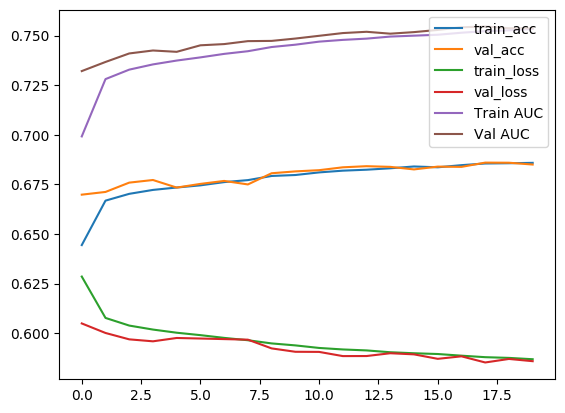


 Acc: 0.7123579545454546, MCC: 0.4534216372206217, SN:0.8872839213829031, SP:0.5375147928994083, 
 CM:[[2271 1954]
 [ 476 3747]]


In [303]:
# Pretraining transformer

n_epo_transformer = 20
model_C = transformer_model()
model_C.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

checkpointer = ModelCheckpoint(filepath="../models/pre_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("PRE Training Transformer model...")

#pre_history_C = model_C.fit(pre_train_ST, pre_train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
#    validation_data=(pre_test_ST, pre_test_ST_labels))

pre_history_C = model_C.fit(pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=1024, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels))

# pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
# validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels)

# Save model
#model_C.save_weights('../models/pre_model_C.h5')


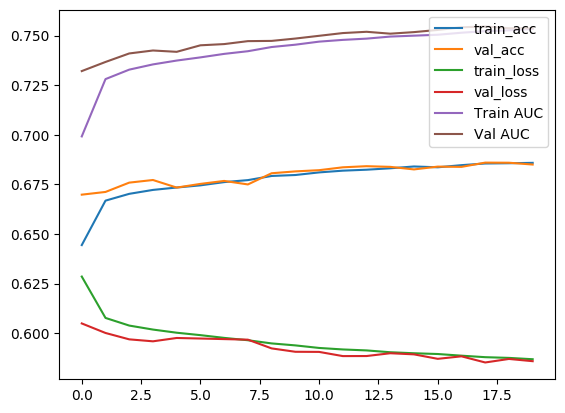


 Acc: 0.6859505855370609, MCC: 0.37350596006201175, SN:0.7322426399043674, SP:0.6396591746243554, 
 CM:[[46019 25924]
 [19263 52679]]


In [304]:
loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/pre_model_C.h5")
y_pred = loaded_model_C.predict(pre_test_ST_CNN).reshape(pre_test_ST_CNN_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_labels = np.array(pre_test_ST_CNN_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_CNN_labels, y_pred)
mcc = matthews_corrcoef(pre_test_ST_CNN_labels, y_pred)
acc = accuracy_score(pre_test_ST_CNN_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

plot(pre_history_C)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

PRE Training RNN model...
Epoch 1/30
132/132 [==============================] - 31s 217ms/step - loss: 0.6606 - accuracy: 0.5877 - auc_roc: 0.6678 - val_loss: 0.6038 - val_accuracy: 0.6796 - val_auc_roc: 0.7262
Epoch 2/30
132/132 [==============================] - 30s 224ms/step - loss: 0.6052 - accuracy: 0.6755 - auc_roc: 0.7253 - val_loss: 0.5959 - val_accuracy: 0.6790 - val_auc_roc: 0.7401
Epoch 3/30
132/132 [==============================] - 35s 263ms/step - loss: 0.5989 - accuracy: 0.6792 - auc_roc: 0.7344 - val_loss: 0.5900 - val_accuracy: 0.6868 - val_auc_roc: 0.7446
Epoch 4/30
132/132 [==============================] - 27s 208ms/step - loss: 0.5944 - accuracy: 0.6826 - auc_roc: 0.7406 - val_loss: 0.5941 - val_accuracy: 0.6869 - val_auc_roc: 0.7487
Epoch 5/30
132/132 [==============================] - 28s 209ms/step - loss: 0.5889 - accuracy: 0.6838 - auc_roc: 0.7471 - val_loss: 0.5868 - val_accuracy: 0.6918 - val_auc_roc: 0.7521
Epoch 6/30
132/132 [=============================

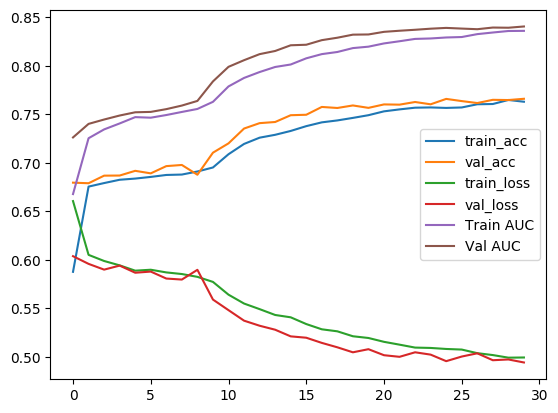


 Acc: 0.7659801136363636, MCC: 0.5319703606024018, SN:0.7627279185413214, SP:0.7692307692307693, 
 CM:[[3250  975]
 [1002 3221]]


In [69]:
### PRE train GRU model
'''

model = Sequential()
model.add(Embedding(256, 21, input_length=33))
model.add(Lambda(lambda x: tf.expand_dims(x, 3)))
model.add(Conv2D(32, kernel_size=(17, 3), activation = 'relu', kernel_initializer='he_normal', padding = 'VALID'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

'''

def RNN_model():
    
    model = Sequential()
    model.add(Embedding(256, 21, input_length=33))
    model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, activation="relu"))
    #model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, activation="relu"))
    model.add(Dropout(0.2))
    #model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, activation="relu"))
    #model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model   

            

# Pretraining transformer

n_epo_RNN = 30
model_D = RNN_model()
model_D.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

checkpointer = ModelCheckpoint(filepath="../models/pre_model_D.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

print("PRE Training RNN model...")

pre_history_D = model_D.fit(pre_train_ST, pre_train_ST_labels, batch_size=1024, epochs=n_epo_RNN, verbose=1, callbacks=[checkpointer],
    validation_data=(pre_test_ST, pre_test_ST_labels))

#pre_history_C = model_C.fit(pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=256, epochs=n_epo_transformer, verbose=1, callbacks=[checkpointer],
#    validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels))

# pre_train_ST_CNN, pre_train_ST_CNN_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer],
# validation_data=(pre_test_ST_CNN, pre_test_ST_CNN_labels)

# Save model
#model_C.save_weights('../models/pre_model_C.h5')

loaded_model_D = RNN_model()
loaded_model_D.load_weights('../models/pre_model_D.h5')
y_pred = loaded_model_D.predict(pre_test_ST).reshape(pre_test_ST_labels.shape[0],)

y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
pre_test_ST_labels = np.array(pre_test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(pre_test_ST_labels, y_pred)
mcc = matthews_corrcoef(pre_test_ST_labels, y_pred)
acc = accuracy_score(pre_test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(pre_history_D)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

In [144]:
## Predict on real data using CNN

loaded_model_A = CNN_model()
loaded_model_A.load_weights('../models/pre_model_A.h5')
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

### Predict on real data using embedding 

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/pre_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

## Predict on real data using transformers

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/pre_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

# Predict on real data using RNN
loaded_model_D = RNN_model()
loaded_model_D.load_weights("../models/pre_model_D.h5")
y_pred = loaded_model_D.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8116591928251121, MCC: 0.6271316882011174, SN:0.8648648648648649, SP:0.7589285714285714, 
 CM:[[170  54]
 [ 30 192]]

 Acc: 0.7982062780269058, MCC: 0.6055560006505397, SN:0.8828828828828829, SP:0.7142857142857143, 
 CM:[[160  64]
 [ 26 196]]

 Acc: 0.7937219730941704, MCC: 0.5890856672626991, SN:0.8288288288288288, SP:0.7589285714285714, 
 CM:[[170  54]
 [ 38 184]]



 Acc: 0.7869955156950673, MCC: 0.5740839816210079, SN:0.7747747747747747, SP:0.7991071428571429, 
 CM:[[179  45]
 [ 50 172]]


Training CNN model...
Epoch 1/50
7/7 [==============================] - 2s 127ms/step - loss: 0.5406 - accuracy: 0.7229 - auc_roc: 0.7629 - val_loss: 0.4937 - val_accuracy: 0.7915 - val_auc_roc: 0.8693
Epoch 2/50
7/7 [==============================] - 0s 44ms/step - loss: 0.5103 - accuracy: 0.7532 - auc_roc: 0.8290 - val_loss: 0.4753 - val_accuracy: 0.8004 - val_auc_roc: 0.8758
Epoch 3/50
7/7 [==============================] - 0s 41ms/step - loss: 0.4820 - accuracy: 0.7656 - auc_roc: 0.8494 - val_loss: 0.4626 - val_accuracy: 0.8094 - val_auc_roc: 0.8838
Epoch 4/50
7/7 [==============================] - 0s 33ms/step - loss: 0.4687 - accuracy: 0.7695 - auc_roc: 0.8573 - val_loss: 0.4478 - val_accuracy: 0.8184 - val_auc_roc: 0.8883
Epoch 5/50
7/7 [==============================] - 0s 20ms/step - loss: 0.4430 - accuracy: 0.7948 - auc_roc: 0.8725 - val_loss: 0.4401 - val_accuracy: 0.7960 - val_auc_roc: 0.8893
Epoch 6/50
7/7 [==============================] - 0s 36ms/step - loss: 0.4242 - ac

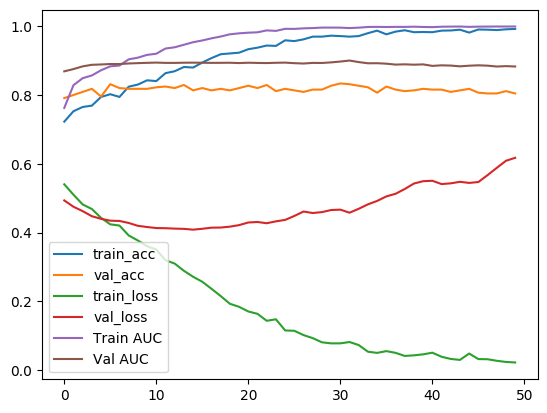


 Acc: 0.804932735426009, MCC: 0.6100501874494875, SN:0.8153153153153153, SP:0.7946428571428571, 
 CM:[[178  46]
 [ 41 181]]



In [301]:
# Training DE-Phosphorylation

iteration = 1
n_epo_cnn = 50

model_A = CNN_model()
model_A.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_A.load_weights('../models/pre_model_A.h5')
#model_A.summary()

print("Training CNN model...")

#metrics = ['accuracy', tf.keras.metrics.AUC()]

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_A.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_A = model_A.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_cnn, verbose=1, callbacks=[checkpointer], 
                        validation_data=(X_test_CNN, test_ST_labels))

# Save model
#model_A.save_weights('../models/re_train_model_A.h5')

y_pred = model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

#save plot
plot(history_A)
print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))
print()

In [146]:
loaded_model_A = CNN_model()
loaded_model_A.load_weights("../models/re_train_model_A.h5")
y_pred = loaded_model_A.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8183856502242153, MCC: 0.6372176236092627, SN:0.7972972972972973, SP:0.8392857142857143, 
 CM:[[188  36]
 [ 45 177]]


Training Embedding model...
Epoch 1/20
7/7 [==============================] - 1s 74ms/step - loss: 0.4912 - accuracy: 0.7707 - auc_roc: 0.8519 - val_loss: 0.4315 - val_accuracy: 0.8296 - val_auc_roc: 0.8863
Epoch 2/20
7/7 [==============================] - 0s 33ms/step - loss: 0.4551 - accuracy: 0.7943 - auc_roc: 0.8686 - val_loss: 0.4290 - val_accuracy: 0.8341 - val_auc_roc: 0.8870
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.4268 - accuracy: 0.8055 - auc_roc: 0.8845 - val_loss: 0.4264 - val_accuracy: 0.8341 - val_auc_roc: 0.8858
Epoch 4/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4132 - accuracy: 0.8139 - auc_roc: 0.8919 - val_loss: 0.4257 - val_accuracy: 0.8229 - val_auc_roc: 0.8867
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3967 - accuracy: 0.8229 - auc_roc: 0.8992 - val_loss: 0.4226 - val_accuracy: 0.8318 - val_auc_roc: 0.8875
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3796 

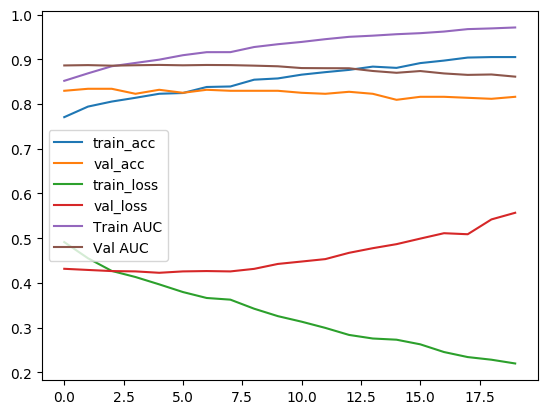


 Acc: 0.8183856502242153, MCC: 0.6372176236092627, SN:0.7972972972972973, SP:0.8392857142857143, 
 CM:[[188  36]
 [ 45 177]]


 Acc: 0.8340807174887892, MCC: 0.6684367400444008, SN:0.8468468468468469, SP:0.8214285714285714, 
 CM:[[184  40]
 [ 34 188]]


In [147]:
########### Model B

print("Training Embedding model...")

n_epo_embed = 20
model_B = prot_t5_model()
model_B.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)
model_B.load_weights('../models/pre_model_B.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='auto')

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_B.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_B = model_B.fit(X_train_full_ST_embedding, train_ST_labels, batch_size=256, epochs=n_epo_embed, verbose=1, 
                        callbacks=[checkpointer], validation_data=(X_test_full_ST_embedding, test_ST_labels))

plot(history_B)
print()

loaded_model_B = prot_t5_model()
loaded_model_B.load_weights("../models/re_train_model_B.h5")
y_pred = loaded_model_B.predict(X_test_full_ST_embedding).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Training Transformer model...
Epoch 1/40
7/7 [==============================] - 4s 101ms/step - loss: 0.5508 - accuracy: 0.7083 - auc_roc: 0.7543 - val_loss: 0.5009 - val_accuracy: 0.7646 - val_auc_roc: 0.8565
Epoch 2/40
7/7 [==============================] - 0s 36ms/step - loss: 0.5316 - accuracy: 0.7470 - auc_roc: 0.8239 - val_loss: 0.4870 - val_accuracy: 0.7758 - val_auc_roc: 0.8571
Epoch 3/40
7/7 [==============================] - 0s 25ms/step - loss: 0.5174 - accuracy: 0.7566 - auc_roc: 0.8287 - val_loss: 0.4782 - val_accuracy: 0.7646 - val_auc_roc: 0.8596
Epoch 4/40
7/7 [==============================] - 0s 24ms/step - loss: 0.5096 - accuracy: 0.7634 - auc_roc: 0.8342 - val_loss: 0.4709 - val_accuracy: 0.7758 - val_auc_roc: 0.8635
Epoch 5/40
7/7 [==============================] - 0s 57ms/step - loss: 0.5017 - accuracy: 0.7656 - auc_roc: 0.8377 - val_loss: 0.4643 - val_accuracy: 0.7825 - val_auc_roc: 0.8665
Epoch 6/40
7/7 [==============================] - 0s 19ms/step - loss: 0.4

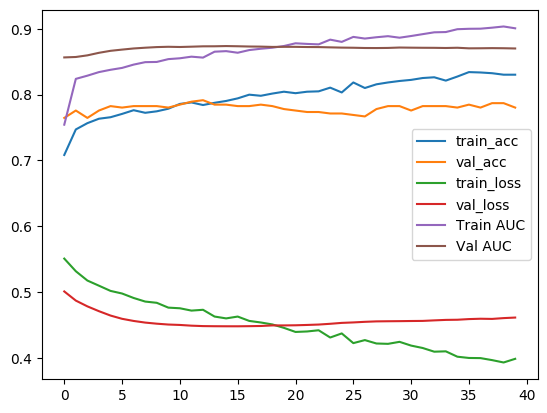



 Acc: 0.7914798206278026, MCC: 0.5829655027090174, SN:0.7927927927927928, SP:0.7901785714285714, 
 CM:[[177  47]
 [ 46 176]]


In [305]:
############# Training Transformer


model_C = transformer_model()
model_C.load_weights('../models/pre_model_C.h5')
model_C.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=metrics)

#model_C.summary()

n_epo_transformer = 40

print("Training Transformer model...")

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_C.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,mode='auto')

history_C = model_C.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1
                        ,callbacks=[checkpointer]
                        , validation_data=(X_test_CNN, test_ST_labels))

plot(history_C)
print()

loaded_model_C = transformer_model()
loaded_model_C.load_weights("../models/re_train_model_C.h5")
y_pred = loaded_model_C.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Training Transformer model...
Epoch 1/30
7/7 [==============================] - 5s 317ms/step - loss: 0.5384 - accuracy: 0.7319 - auc_roc: 0.8345 - val_loss: 0.4776 - val_accuracy: 0.7915 - val_auc_roc: 0.8629
Epoch 2/30
7/7 [==============================] - 2s 219ms/step - loss: 0.5235 - accuracy: 0.7369 - auc_roc: 0.8155 - val_loss: 0.4718 - val_accuracy: 0.7870 - val_auc_roc: 0.8620
Epoch 3/30
7/7 [==============================] - 2s 237ms/step - loss: 0.5093 - accuracy: 0.7544 - auc_roc: 0.8297 - val_loss: 0.4734 - val_accuracy: 0.7803 - val_auc_roc: 0.8621
Epoch 4/30
7/7 [==============================] - 1s 208ms/step - loss: 0.5028 - accuracy: 0.7600 - auc_roc: 0.8349 - val_loss: 0.4683 - val_accuracy: 0.8049 - val_auc_roc: 0.8647
Epoch 5/30
7/7 [==============================] - 1s 214ms/step - loss: 0.4966 - accuracy: 0.7499 - auc_roc: 0.8399 - val_loss: 0.4608 - val_accuracy: 0.7982 - val_auc_roc: 0.8677
Epoch 6/30
7/7 [==============================] - 1s 206ms/step - loss

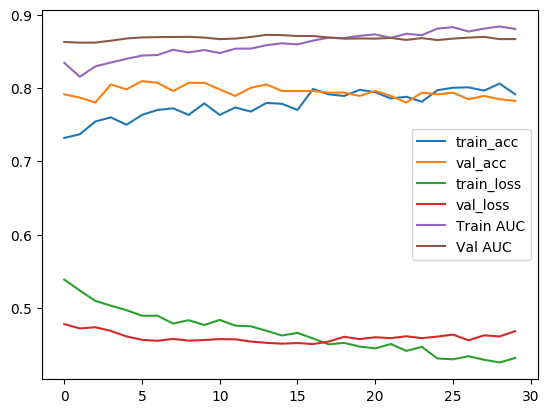


 Acc: 0.8094170403587444, MCC: 0.6190779266209061, SN:0.7927927927927928, SP:0.8258928571428571, 
 CM:[[185  39]
 [ 46 176]]


In [70]:
model_D = RNN_model()
model_D.load_weights('../models/pre_model_D.h5')
model_D.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy(), metrics=metrics)

n_epo_RNN = 30

print("Training Transformer model...")

checkpointer = ModelCheckpoint(filepath="../models/re_train_model_D.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)

history_D = model_D.fit(X_train_CNN, train_ST_labels, batch_size=256, epochs=n_epo_transformer, verbose=1
                        ,callbacks=[checkpointer], validation_data=(X_test_CNN, test_ST_labels))

plot(history_D)
print()

loaded_model_D = RNN_model()
loaded_model_D.load_weights("../models/re_train_model_D.h5")
y_pred = loaded_model_D.predict(X_test_CNN).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))

Loaded 3 models
Epoch 1/20
56/56 [==============================] - 3s 24ms/step - loss: 0.5456 - accuracy: 0.6830 - auc_roc: 0.9660 - val_loss: 0.5640 - val_accuracy: 0.7287 - val_auc_roc: 0.9138
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 0.4694 - accuracy: 0.8499 - auc_roc: 0.9854 - val_loss: 0.5241 - val_accuracy: 0.8049 - val_auc_roc: 0.9131
Epoch 3/20
56/56 [==============================] - 1s 16ms/step - loss: 0.4002 - accuracy: 0.9359 - auc_roc: 0.9856 - val_loss: 0.4874 - val_accuracy: 0.8274 - val_auc_roc: 0.9113
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 0.3293 - accuracy: 0.9550 - auc_roc: 0.9890 - val_loss: 0.4581 - val_accuracy: 0.8318 - val_auc_roc: 0.9057
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 0.2676 - accuracy: 0.9657 - auc_roc: 0.9927 - val_loss: 0.4381 - val_accuracy: 0.8408 - val_auc_roc: 0.9021
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 0.2312

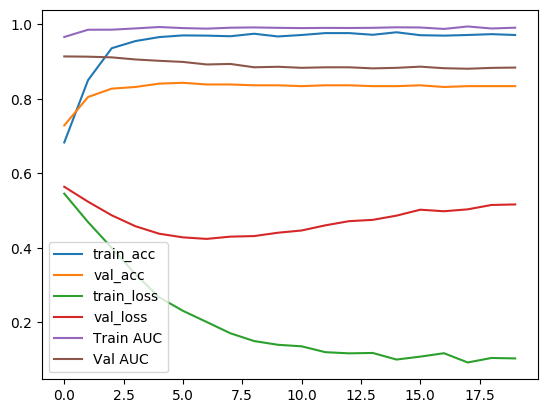

In [384]:
# load models from file
def load_A_models():
    model = CNN_model()
    model.load_weights('../models/re_train_model_A.h5')
    return model


def load_B_models():
    model = prot_t5_model()
    model.load_weights('../models/re_train_model_B.h5')
    return model


def load_C_models():
    model = transformer_model()
    model.load_weights('../models/re_train_model_C.h5')
    return model

def load_D_models():
    model = RNN_model()
    model.load_weights('../models/re_train_model_D.h5')
    return model


# meta learner
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
    ensemble_inputs = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    #ensemble_outputs = [model.get_layer(index = len(model.layers) - 1).output for model in members]
    #print(ensemble_outputs)
    #for item in ensemble_outputs:
    #    print(item)
    # outputs=re_stacked_model.get_layer(index=26).output
    merge = concatenate(ensemble_outputs)
    hidden = Dropout(0.4, name = 'dp_2')(merge)
    hidden = Dense(64, activation='relu', name = 'ds_1')(merge)
    hidden = Dropout(0.4, name = 'dp_1')(hidden)
    hidden = Dense(32, activation='relu', name = 'ds_2')(merge)
    hidden = Dropout(0.4, name = 'dp_3')(hidden)
    output = Dense(1, activation='sigmoid', name = 'ds_4')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    #model.summary()
    return model


# load all models
members = list()
model_A = load_A_models()
model_B = load_B_models()
model_C = load_C_models()
model_D = load_D_models()

members.append(model_A)
members.append(model_B)
members.append(model_C)
#members.append(model_D)

n_epo_stacked = 20


print('Loaded %d models' % len(members))
stacked_model = define_stacked_model(members)


checkpointer = ModelCheckpoint(filepath="../models/pre_re_train_composite_model.h5",
                                monitor = "val_accuracy",
                                verbose=0, 
                                save_weights_only=True,
                                save_best_only=True)


st_history = stacked_model.fit([X_train_CNN, X_train_full_ST_embedding, X_train_CNN], train_ST_labels, 
                               epochs=n_epo_stacked, verbose=1, callbacks = [checkpointer],
                               validation_data=([X_test_CNN, X_test_full_ST_embedding, X_test_CNN], test_ST_labels))

# X_train_full_ST_embedding, X_test_full_ST_embedding


plot(st_history)
print()

In [391]:
# Predict
re_stacked_model = define_stacked_model(members)
re_stacked_model.load_weights("../models/pre_re_train_composite_model.h5")
y_pred = re_stacked_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN]).reshape(test_ST_labels.shape[0],)
y_pred = (y_pred > 0.5)
y_pred = [int(i) for i in y_pred]
test_ST_labels = np.array(test_ST_labels)
y_pred = np.array(y_pred)

cm = confusion_matrix(test_ST_labels, y_pred)
mcc = matthews_corrcoef(test_ST_labels, y_pred)
acc = accuracy_score(test_ST_labels, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])

print("\n Acc: %s, MCC: %s, SN:%s, SP:%s, \n CM:%s" %(str(acc), str(mcc), str(sn), str(sp), cm))


 Acc: 0.8430493273542601, MCC: 0.6871632621253926, SN:0.8693693693693694, SP:0.8169642857142857, 
 CM:[[183  41]
 [ 29 193]]


In [392]:
# load pretrained model
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.manifold import TSNE
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
import h5py

#re_stacked_model.summary()

print("Number of layers: ", len(re_stacked_model.layers))

# create truncated model
truncated_ANN_model = Model(inputs=re_stacked_model.input,
                                 outputs=re_stacked_model.get_layer(index=len(re_stacked_model.layers) - 2).output) #20

hidden_features = truncated_ANN_model.predict([X_test_CNN, X_test_full_ST_embedding, X_test_CNN])

hidden_labels = test_ST_labels #train_ST_labels

print(hidden_features.shape)

df = pd.DataFrame()
df['Target'] = hidden_labels

Number of layers:  31
(446, 32)


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


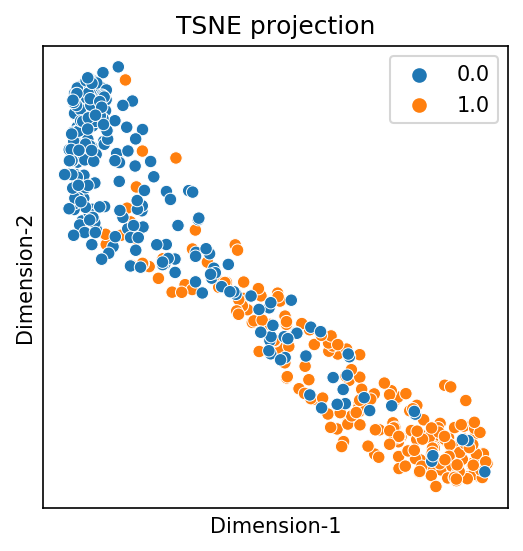

In [393]:
m = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)
tsne_features = m.fit_transform(hidden_features)
df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

In [394]:
#!pip install umap-learn

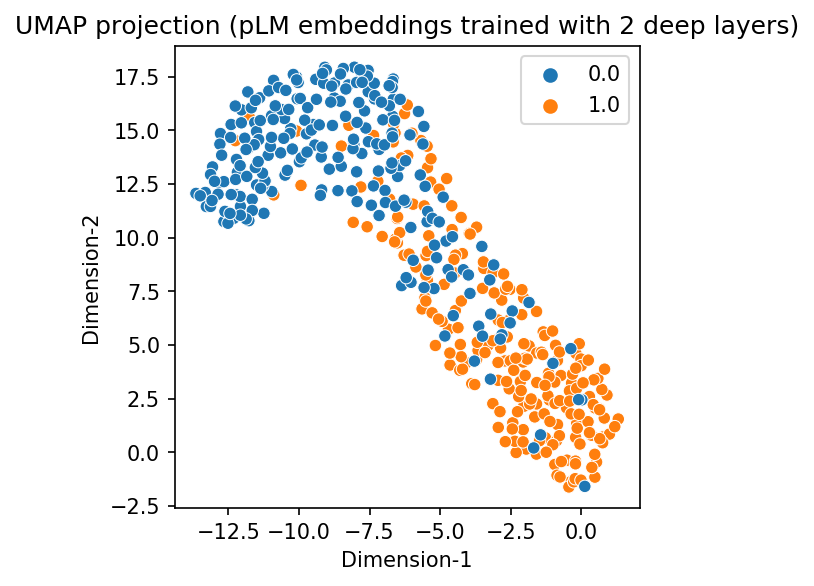

In [395]:
from umap import UMAP
from matplotlib.pyplot import figure

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

n_neighbors = 100

min_dist = 0.99

n_components = 2

metric = "hsl_dist" #'euclidean'

umap_2d = UMAP(n_components=n_components, n_neighbors = n_neighbors, min_dist = min_dist, init = 'random', random_state = 0)

proj_2d = umap_2d.fit_transform(hidden_features)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings trained with 2 deep layers)")
filename = "UMAP_Embedding_Pos_Neg.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


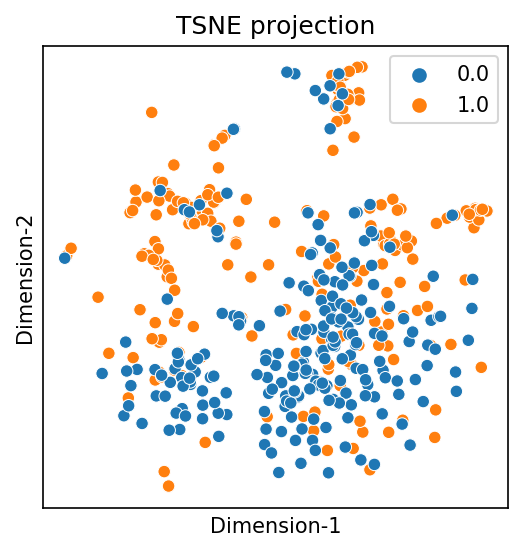

In [396]:
hidden_features_raw = X_test_full_ST_embedding
df = pd.DataFrame()
df['Target'] = test_ST_labels

m_raw = TSNE(learning_rate = "auto", perplexity = 100, random_state = 20)

tsne_features = m_raw.fit_transform(hidden_features_raw)

df['Dimension-1'] = tsne_features[:,0]
df['Dimension-2'] = tsne_features[:,1]

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

sns.scatterplot(x="Dimension-1", y="Dimension-2", hue='Target',data=df)
plt.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

plt.title("TSNE projection")
plt.legend().set_visible(True)
filename = "TSNE_Embedding_Pos_Neg_Raw.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

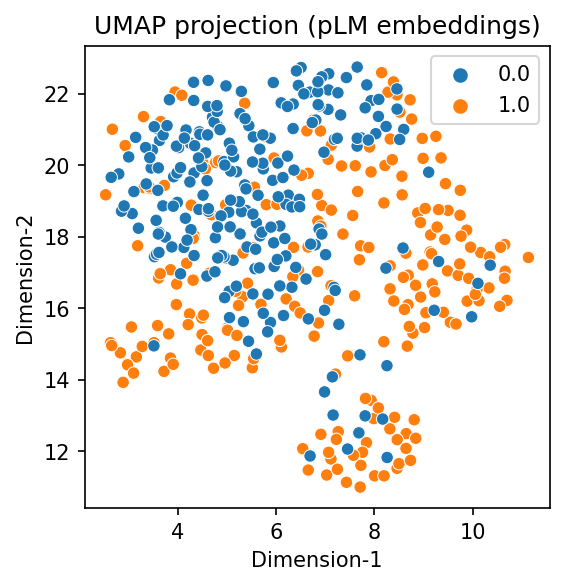

In [171]:

figsize = (4, 4)
figure(figsize=figsize, dpi=150)

n_colors = 10

#n_neighbors = 1000

#min_dist = 0.99

#n_components=2

#metric='euclidean'

umap_2d_raw = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, init='random', random_state=0)

proj_2d = umap_2d_raw.fit_transform(hidden_features_raw)

df_umap = pd.DataFrame()

df_umap["Dimension-1"] = proj_2d[:,0]
df_umap["Dimension-2"] = proj_2d[:,1]

sns_plot = sns.scatterplot(x="Dimension-1", y="Dimension-2", hue=hidden_labels, data=df_umap).set(title="UMAP projection (pLM embeddings)")
filename = "UMAP_Embedding_Pos_Neg_pLM_embeddings.png"
plt.savefig(filename, dpi=150, bbox_inches='tight')